# ETL
## Names & Admin No:
### Quah Johnnie (2007476), Jayden Yap (2112790), Bey Wee Loon (2112802)

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Connect to MSSQL server
server = 'DAAA-NB2112802\SQLEXPRESS' # <- change server
database = 'Taxi_Trip'
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL Server')

## 1. Extracting data

Loading data from MS SQL into python

### 1.1 Driver Table

In [3]:
%%time
# Retrieve Data
connection = engine.connect()
cursor = connection.execute('SELECT * FROM dataLake.drivers')
drivers_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())
connection.close()

Wall time: 559 ms


In [4]:
display(drivers_df.head(5))
print(f'Shape: {drivers_df.shape}')

,driver_id,name,date_of_birth,gender,car_model,car_make_year,rating
0,1,Tressa,1/12/1992,Female,Mazda,2011,4.5
1,2,Virgilio,10/23/1992,Male,Mazda,2004,3.5
2,3,Bert,8/10/1989,Male,Nissan,2008,4.5
3,4,Mahmoud,8/14/1981,Male,Toyota,2008,4.5
4,5,Felecia,7/20/1990,Female,Hyundai,2010,4.5


Shape: (148, 7)


### 1.2 Safety Labels Table

In [5]:
%%time
# Retrieve Data
connection = engine.connect()
cursor = connection.execute('SELECT * FROM dataLake.safety_labels')
safety_labels_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())
connection.close()

Wall time: 176 ms


In [6]:
display(safety_labels_df.head(5))
print(f'Shape: {safety_labels_df.shape}')

,booking_id,driver_id,label
0,0,48,0
1,1,74,1
2,2,40,1
3,4,112,1
4,6,68,0


Shape: (20000, 3)


### 1.3 Sensor Table

In [7]:
%%time
# Retrieve Data
connection = engine.connect()
cursor = connection.execute('SELECT * FROM dataLake.sensor')
sensor_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())
connection.close()

Wall time: 2min 15s


In [8]:
display(sensor_df.head(5))
print(f'Shape: {sensor_df.shape}')
#7+ million rows

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3
3,1073741824054,3.900,126.0,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5


Shape: (7469656, 12)


## 2. Explore + Data Wrangle

### 2.1 Drivers data

- __Data Info__

In [9]:
display(drivers_df)

,driver_id,name,date_of_birth,gender,car_model,car_make_year,rating
0,1,Tressa,1/12/1992,Female,Mazda,2011,4.5
1,2,Virgilio,10/23/1992,Male,Mazda,2004,3.5
2,3,Bert,8/10/1989,Male,Nissan,2008,4.5
3,4,Mahmoud,8/14/1981,Male,Toyota,2008,4.5
4,5,Felecia,7/20/1990,Female,Hyundai,2010,4.5
...,...,...,...,...,...,...,...
143,144,Adena,12/31/1982,Female,Chevrolet,2011,4.0
144,145,Shari,11/19/1992,Female,Mazda,2011,5.0
145,146,Sid,6/29/1984,Male,Volkswagen,2010,5.0
146,147,Delila,11/8/1982,Female,Toyota,2011,3.0


In [10]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   driver_id      148 non-null    int64 
 1   name           148 non-null    object
 2   date_of_birth  148 non-null    object
 3   gender         148 non-null    object
 4   car_model      148 non-null    object
 5   car_make_year  148 non-null    object
 6   rating         148 non-null    object
dtypes: int64(1), object(6)
memory usage: 8.2+ KB


In [11]:
#descriptive stats of ratings column
drivers_df['rating'].describe()

count     148
unique      5
top       4.0
freq       50
Name: rating, dtype: object

In [12]:
# Changing datatype
drivers_df = drivers_df.astype({
    'car_make_year': 'int16',
    'rating': float
})
drivers_df['date_of_birth'] = pd.to_datetime(drivers_df['date_of_birth'], format='%m/%d/%Y')

- __Feature Engineering__

In [13]:
# Creating 'year', 'age' and 'month' column from date of birth
drivers_df['DOB_year'] = pd.DatetimeIndex(drivers_df['date_of_birth']).year
drivers_df['DOB_month'] = pd.DatetimeIndex(drivers_df['date_of_birth']).month_name().str[:3]
drivers_df = drivers_df[['driver_id', 'name', 'date_of_birth', 'DOB_year', 'DOB_month', 'gender',
                        'car_model', 'car_make_year', 'rating']]
drivers_df['age'] = 2022 - drivers_df['DOB_year'] 
drivers_df['car_age'] = 2022 - drivers_df['car_make_year'] 
drivers_df

,driver_id,name,date_of_birth,DOB_year,DOB_month,gender,car_model,car_make_year,rating,age,car_age
0,1,Tressa,1992-01-12,1992,Jan,Female,Mazda,2011,4.5,30,11
1,2,Virgilio,1992-10-23,1992,Oct,Male,Mazda,2004,3.5,30,18
2,3,Bert,1989-08-10,1989,Aug,Male,Nissan,2008,4.5,33,14
3,4,Mahmoud,1981-08-14,1981,Aug,Male,Toyota,2008,4.5,41,14
4,5,Felecia,1990-07-20,1990,Jul,Female,Hyundai,2010,4.5,32,12
...,...,...,...,...,...,...,...,...,...,...,...
143,144,Adena,1982-12-31,1982,Dec,Female,Chevrolet,2011,4.0,40,11
144,145,Shari,1992-11-19,1992,Nov,Female,Mazda,2011,5.0,30,11
145,146,Sid,1984-06-29,1984,Jun,Male,Volkswagen,2010,5.0,38,12
146,147,Delila,1982-11-08,1982,Nov,Female,Toyota,2011,3.0,40,11


- __Check Duplicates__

In [14]:
# Check whether there is any duplicate in general
display(drivers_df[drivers_df.duplicated()])

# Check whether there is any duplicated ID
display(drivers_df[drivers_df.duplicated(['driver_id'])])

,driver_id,name,date_of_birth,DOB_year,DOB_month,gender,car_model,car_make_year,rating,age,car_age


,driver_id,name,date_of_birth,DOB_year,DOB_month,gender,car_model,car_make_year,rating,age,car_age


### 2.2 Safety Labels Data 

- __Data Info__

In [15]:
display(safety_labels_df)

,booking_id,driver_id,label
0,0,48,0
1,1,74,1
2,2,40,1
3,4,112,1
4,6,68,0
...,...,...,...
19995,1709396983957,72,1
19996,1709396983960,101,1
19997,1709396983966,39,1
19998,1709396983971,98,1


In [16]:
safety_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   booking_id  20000 non-null  int64
 1   driver_id   20000 non-null  int64
 2   label       20000 non-null  int64
dtypes: int64(3)
memory usage: 468.9 KB


In [17]:
safety_labels_df.describe()

,booking_id,driver_id,label
count,2.000000e+04,20000.000000,20000.000000
mean,8.162027e+11,74.444050,0.249650
std,4.945137e+11,42.746576,0.432821
min,0.000000e+00,1.000000,0.000000
25%,3.865471e+11,37.000000,0.000000
50%,7.988639e+11,75.000000,0.000000
75%,1.245541e+12,111.000000,0.000000
max,1.709397e+12,148.000000,1.000000


In [18]:
#no nulls
safety_labels_df.isna().sum()

booking_id    0
driver_id     0
label         0
dtype: int64

In [19]:
#148 unique drivers (all drivers included)
safety_labels_df.nunique()

booking_id    20000
driver_id       148
label             2
dtype: int64

- __Check duplicates__

In [20]:
# Check whether there is any duplicate in general
display(safety_labels_df[safety_labels_df.duplicated()])

# Check whether there is any duplicated booking and driver id
display(safety_labels_df[safety_labels_df.duplicated(['booking_id','driver_id'])])

,booking_id,driver_id,label


,booking_id,driver_id,label


### 2.3 Sensor Data 

- __Data Info__

In [21]:
display(sensor_df)

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
0,1202590843006,3.000,353.000000,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1
1,274877907034,9.293,17.000000,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2
2,884763263056,3.000,189.000000,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3
3,1073741824054,3.900,126.000000,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4
4,1056561954943,3.900,50.000000,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5
...,...,...,...,...,...,...,...,...,...,...,...,...
7469651,884763262985,3.900,226.000000,0.260422,9.907822,3.162796,0.013733,0.010056,0.017792,98.0,9.980000,7469652
7469652,1571958030347,5.000,341.782990,-1.168625,-9.396103,-0.009271,0.032545,0.009954,0.038534,509.0,6.440000,7469653
7469653,584115552361,6.000,50.000000,6.186806,6.809318,0.234639,0.505468,0.255951,0.202501,519.0,NaN,7469654
7469654,1073741824126,10.720,324.000000,-0.274582,8.512177,3.903046,-0.037451,-0.044601,-0.033173,2289.0,8.770000,7469655


In [22]:
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   accuracy        float64
 2   bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  sensorKey       int64  
dtypes: float64(10), int64(2)
memory usage: 683.9 MB


In [23]:
sensor_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
count,7469656.00000,7351631.00000,7350253.00000,7364539.00000,7346553.00000,7370520.00000,7336398.00000,7329944.00000,7404168.00000,7469656.00000,7346079.00000,7469656.00000
mean,818337115784.25378,11.62066,168.96987,0.06919,4.46798,0.89645,-0.00174,0.00020,-0.00025,3669.33466,9.00392,3734828.50000
std,495334756422.75836,87.27007,107.29417,1.42402,8.13044,3.25222,0.14460,0.33713,0.14801,1378355.46436,8.10556,2156304.09551
min,0.00000,0.75000,0.00000,-38.98399,-57.80019,-78.44842,-48.45575,-57.34489,-53.55445,0.00000,-2.00000,1.00000
25%,377957122216.00000,3.90000,78.00000,-0.50872,-2.02651,-0.92952,-0.02679,-0.02996,-0.01872,241.00000,1.01797,1867414.75000
50%,807453851664.00000,4.24700,168.84042,0.06131,9.08149,0.77766,-0.00066,0.00026,-0.00003,520.00000,7.52490,3734828.50000
75%,1254130450446.00000,8.00000,263.00000,0.63553,9.71031,2.75304,0.02329,0.03142,0.01825,862.00000,15.47718,5602242.25000
max,1709396983975.00000,6070.10100,359.99948,66.87346,72.81000,78.05576,38.70809,80.31496,45.05986,619316528.00000,88.03725,7469656.00000


In [24]:
# Changing datatype
sensor_df_cols = list(sensor_df.columns[1:])
temp_df = sensor_df[sensor_df_cols]

In [25]:
temp_df = temp_df.astype(np.float32)
temp_df['booking_id'] = sensor_df['booking_id'].copy()
cols = ['booking_id'] + sensor_df_cols
sensor_df = temp_df[cols].copy()

In [26]:
sensor_df.head(5)

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1.0
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2.0
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3.0
3,1073741824054,3.900,126.0,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4.0
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5.0


- __Checking duplicates__

In [27]:
# Check whether there is any duplicate in general
display(sensor_df[sensor_df.duplicated()])

# Check whether there is any items that only has different booking id
display(sensor_df[sensor_df.duplicated(sensor_df.columns[1:])])

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey


,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey


### 2.4 Identify Outliers

In [28]:
import matplotlib.pyplot as plt
def outlierAnalysis(df,columnNames,magnitude=24):
    for columnName in columnNames:
        fig, ax = plt.subplots(figsize=(6,3))
        sns.boxplot(data=df,x=columnName)
        plt.title(f'Min:{df[columnName].min():.2f} Max:{df[columnName].max():.2f} Mean: {df[columnName].mean():.2f}')
        plt.show()
        
            
            
def returnOutliers(df,columnName,magnitude=1.5):
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)
    lowerFence = df[columnName].quantile(0.25) - (IQR * magnitude)
    upperFence = df[columnName].quantile(0.75) + (IQR * magnitude)
    outlier_df = df[columnName][(df[columnName]<=lowerFence) | (df[columnName]>=upperFence)]
    print('Number of outliers: ',len(outlier_df))
    return outlier_df

def returnUpper(df,columnName,magnitude=3):
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)
    upperFence = df[columnName].quantile(0.75) + (IQR * magnitude)
    outlier_df = df[columnName][(df[columnName]>=upperFence)]
    print('Number of outliers: ',len(outlier_df))
    return outlier_df

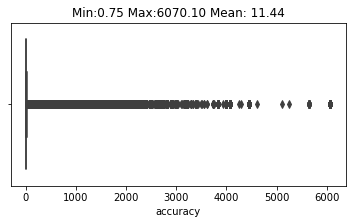

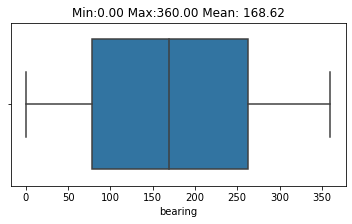

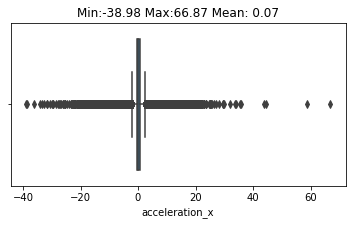

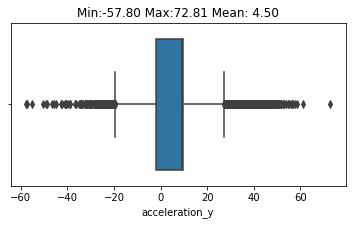

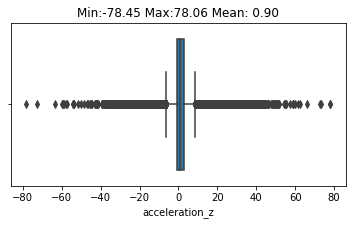

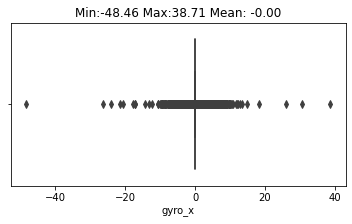

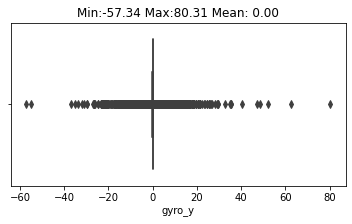

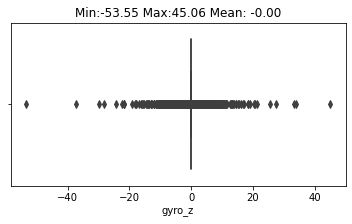

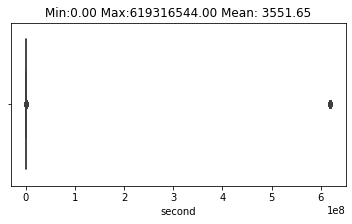

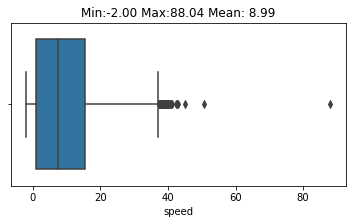

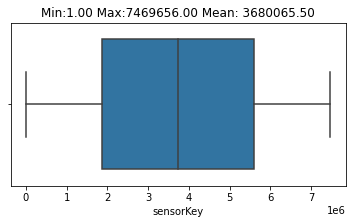

In [29]:
outlierAnalysis(sensor_df, sensor_df.columns.drop('booking_id','seconds'))

### 2.5 Handling Missing Values
Sensor data has many missing values, let's use SKLearn's iterative imputer to impute them (other 2 dataframes have no missing values)

- __Identify Null Values__

In [30]:
print('Sensor Data:')
display(sensor_df.isna().sum())

Sensor Data:


booking_id             0
accuracy          118025
bearing           119403
acceleration_x    105117
acceleration_y    123103
acceleration_z     99136
gyro_x            133258
gyro_y            139712
gyro_z             65488
second                 0
speed             123577
sensorKey              0
dtype: int64

Removing accuracy, as it does not make sense to impute a predicted accuracy

In [31]:
sensor_df = sensor_df.dropna(how='any', axis=0, subset=['accuracy']).reset_index(drop=True)
display(sensor_df.isna().sum())

booking_id             0
accuracy               0
bearing           116319
acceleration_x    103256
acceleration_y    121048
acceleration_z     96114
gyro_x            130749
gyro_y            138006
gyro_z             65084
second                 0
speed             120829
sensorKey              0
dtype: int64

In [32]:
sensor_df

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
0,1202590843006,3.000,353.000000,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1.0
1,274877907034,9.293,17.000000,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2.0
2,884763263056,3.000,189.000000,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3.0
3,1073741824054,3.900,126.000000,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4.0
4,1056561954943,3.900,50.000000,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7351626,884763262985,3.900,226.000000,0.260422,9.907822,3.162796,0.013733,0.010056,0.017792,98.0,9.980000,7469652.0
7351627,1571958030347,5.000,341.782990,-1.168625,-9.396103,-0.009271,0.032545,0.009954,0.038534,509.0,6.440000,7469653.0
7351628,584115552361,6.000,50.000000,6.186806,6.809318,0.234639,0.505468,0.255951,0.202501,519.0,NaN,7469654.0
7351629,1073741824126,10.720,324.000000,-0.274582,8.512177,3.903046,-0.037451,-0.044601,-0.033173,2289.0,8.770000,7469655.0


Save missing indicies to observe later

In [33]:
missing_indicies = sensor_df.isin([True]).any(axis=1)

Means of our sensor_df values before imputation

In [34]:
sensor_df[['accuracy','bearing','acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','speed']].mean()

accuracy           11.442951
bearing           168.624557
acceleration_x      0.069192
acceleration_y      4.496274
acceleration_z      0.896253
gyro_x             -0.001735
gyro_y              0.000177
gyro_z             -0.000250
speed               8.993378
dtype: float32

- __Imputing Null Values__

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

imp_mean = IterativeImputer(
   estimator=LinearRegression(),
   random_state=1
)

# Passing all columns except 'booking_id'
sensor_df_cols = list(sensor_df.columns[1:])
num_df = sensor_df[sensor_df_cols]

# Imputing null values
sensor_list = imp_mean.fit_transform(num_df)
newSensor_df = pd.DataFrame(sensor_list, columns=sensor_df_cols)
newSensor_df['booking_id'] = sensor_df['booking_id'].copy()

# Display
display(newSensor_df.isna().sum())
# no more null values!

accuracy          0
bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
sensorKey         0
booking_id        0
dtype: int64

Means of new imputed data - does not seems off.

In [36]:
newSensor_df[['accuracy','bearing','acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','speed']].mean()

accuracy           11.442951
bearing           168.587021
acceleration_x      0.069194
acceleration_y      4.496160
acceleration_z      0.896165
gyro_x             -0.001735
gyro_y              0.000179
gyro_z             -0.000251
speed               8.992186
dtype: float32

Means of the imputed data that is used to replace the missing data

In [37]:
newSensor_df[missing_indicies][['accuracy','bearing','acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','speed']].mean()

accuracy           7.305315
bearing           72.391960
acceleration_x     0.063331
acceleration_y     7.208873
acceleration_z     1.365744
gyro_x             0.001910
gyro_y             0.001672
gyro_z             0.000309
speed              6.921623
dtype: float32

- __Removing unnecessary data__

If driver id in safety labels does not match driver ids in drivers data, remove safety labels

In [38]:
comparing=safety_labels_df.driver_id.isin(drivers_df.driver_id)
print(comparing)
print(comparing.unique())
# this shows that all values of driverid in safety labels do match a value in driver data

0        True
1        True
2        True
3        True
4        True
         ... 
19995    True
19996    True
19997    True
19998    True
19999    True
Name: driver_id, Length: 20000, dtype: bool
[ True]


In [39]:
comparing=safety_labels_df.booking_id.isin(newSensor_df.booking_id)
print(comparing)
print(comparing.unique())
# this shows that all values of driverid in safety labels do match a value in driver data

0        True
1        True
2        True
3        True
4        True
         ... 
19995    True
19996    True
19997    True
19998    True
19999    True
Name: booking_id, Length: 20000, dtype: bool
[ True]


All values seem to match as there is only 1 true value

### 2.6 Feature Engineering + Removing outliers
- Outliers will be saved (Outliers could be important for ML, if we assume that the same sensor is fault, it might be good to train the model with these outliers so when the sensor is faulty again it will not be an outlier for the model)

__Net Acceleration__ 

$\sqrt{ (acceleration_x)^2 +  + (acceleration_y)^2 + (acceleration_z)^2 }$

In [40]:
newSensor_df['acceleration'] = ((newSensor_df['acceleration_x'] ** 2 
                              + newSensor_df['acceleration_y'] ** 2 
                              + newSensor_df['acceleration_z'] ** 2) ** (1/2))

Dropping impossible acceleration using 10 sigma upper fence (original 1.5)
- Lower fence not used since 0 acceleration is possible

The fastest commercial car can accelerate at about ~10.5 m/s^2. However, the cutoff for values to drop is 13.7m/s^2, this is because we added some leeway incase some of these values are due to high inaccuracy or if the car crashed. High inaccuracy and car crashing could lead to a very high acceleration.


In [41]:
returnUpper(newSensor_df,'acceleration',6).min()

Number of outliers:  33650


13.729136226236328

Dropping & saving outliers anything where acceleration >= 13.7291 m/s^2

In [42]:
outlier_df = newSensor_df.loc[returnUpper(newSensor_df,'acceleration',6).index]

Number of outliers:  33650


In [43]:
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'acceleration',6).index)

Number of outliers:  33650


__Net Gyro__

$\sqrt{ (gyro_x)^2 +  + (gyro_y)^2 + (gyro_z)^2 }$

In [44]:
newSensor_df['gyro'] = ((newSensor_df['gyro_x'] ** 2 
                              + newSensor_df['gyro_y'] ** 2 
                              + newSensor_df['gyro_z'] ** 2) ** (1/2))

Dropping impossible gyro values as well 2.85rad/s or 163 degrees/s seems impossible even for roundabout or tokyo drift...

In [45]:
returnUpper(newSensor_df,'gyro',24).min()

Number of outliers:  12307


2.8525317073467313

Dropping & saving anything where gyro >= 2.8526 rad/s

In [46]:
outlier_df = pd.concat([outlier_df,newSensor_df.loc[returnUpper(newSensor_df,'gyro',24).index]])

Number of outliers:  12307


In [47]:
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'gyro',24).index)

Number of outliers:  12307


Dropping & saving impossible speed
- For reference: 200km/h is 55.55m/s
- Another reference: 316km/h is 88m/s -> this seems impossible
- Seems like most of the outliers/faulty sensor values are already gone except 1

In [48]:
returnUpper(newSensor_df,'speed',3).min()

Number of outliers:  1


88.0372543334961

In [49]:
outlier_df = pd.concat([outlier_df, newSensor_df.loc[returnUpper(newSensor_df,'speed',3).index]])

Number of outliers:  1


In [50]:
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'speed',3).index)

Number of outliers:  1


In [51]:
returnUpper(newSensor_df,'second',12).min()

Number of outliers:  35


619315328.0

In [52]:
outlier_df = pd.concat([outlier_df,newSensor_df.loc[returnUpper(newSensor_df,'second',12).index]])

Number of outliers:  35


In [53]:
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'second',12).index)

Number of outliers:  35


In [54]:
newSensor_df

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey,booking_id,acceleration,gyro
0,3.000,353.000000,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1.0,1202590843006,9.829436,0.013116
1,9.293,17.000000,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2.0,274877907034,9.871045,0.027216
2,3.000,189.000000,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3.0,884763263056,9.809800,0.016622
3,3.900,126.000000,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4.0,1073741824054,11.085306,0.340078
4,3.900,50.000000,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5.0,1056561954943,10.666275,0.216672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351626,3.900,226.000000,0.260422,9.907822,3.162796,0.013733,0.010056,0.017792,98.0,9.980000,7469652.0,884763262985,10.403655,0.024622
7351627,5.000,341.782990,-1.168625,-9.396103,-0.009271,0.032545,0.009954,0.038534,509.0,6.440000,7469653.0,1571958030347,9.468501,0.051411
7351628,6.000,50.000000,6.186806,6.809318,0.234639,0.505468,0.255951,0.202501,519.0,8.132320,7469654.0,584115552361,9.203175,0.601677
7351629,10.720,324.000000,-0.274582,8.512177,3.903046,-0.037451,-0.044601,-0.033173,2289.0,8.770000,7469655.0,1073741824126,9.368367,0.067024


- __Joining Labels table to Sensor Data table__

Tables are joined such that it can be used for exploratory data analysis later on.

In [55]:
merged_df_sensor = newSensor_df.merge(safety_labels_df, on='booking_id', how='inner')

In [56]:
merged_df_sensor

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey,booking_id,acceleration,gyro,driver_id,label
0,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1.0,1202590843006,9.829436,0.013116,90,1
1,3.033,77.0,1.137217,8.975278,3.981050,0.021118,-0.022515,0.024522,541.0,8.281786,36005.0,1202590843006,9.884211,0.039424,90,1
2,6.173,283.0,1.522818,7.947064,5.075056,0.137567,-0.297055,-0.017418,154.0,2.863286,37793.0,1202590843006,9.551492,0.327826,90,1
3,3.014,353.0,1.134775,8.932489,3.929421,-0.007959,-0.020543,-0.022986,1384.0,0.000000,57022.0,1202590843006,9.824329,0.031839,90,1
4,5.209,340.0,0.858197,9.078037,2.944571,-0.001617,0.015219,0.025517,1142.0,9.750134,76232.0,1202590843006,9.582159,0.029755,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7305633,8.000,174.0,-3.599874,0.003059,-3.146900,0.632403,0.298277,0.434988,364.0,5.671403,2527091.0,1125281431597,4.781431,0.823479,14,0
7305634,6.000,310.0,0.209780,2.376410,-1.082380,0.318121,-0.580270,-0.253090,1030.0,4.763514,5087843.0,1125281431597,2.619710,0.708497,14,0
7305635,4.925,267.0,3.340773,-0.685852,-5.603629,0.022864,-0.839416,-0.340618,1376.0,0.060815,6414898.0,1125281431597,6.559864,0.906180,14,0
7305636,6.000,44.0,-0.400224,7.775768,4.264150,0.871391,-0.340182,-0.474258,631.0,10.434990,5932757.0,1116691497052,8.877259,1.048793,3,0


- __Joining Labels table to Drivers table__

In [57]:
merged_df_labels = safety_labels_df.merge(drivers_df, on='driver_id', how='inner')

In [58]:
merged_df_labels

,booking_id,driver_id,label,name,date_of_birth,DOB_year,DOB_month,gender,car_model,car_make_year,rating,age,car_age
0,0,48,0,Lilia,1974-08-13,1974,Aug,Male,Mercedes-Benz,2013,4.0,48,9
1,119,48,1,Lilia,1974-08-13,1974,Aug,Male,Mercedes-Benz,2013,4.0,48,9
2,8589934611,48,0,Lilia,1974-08-13,1974,Aug,Male,Mercedes-Benz,2013,4.0,48,9
3,25769803794,48,0,Lilia,1974-08-13,1974,Aug,Male,Mercedes-Benz,2013,4.0,48,9
4,25769803869,48,0,Lilia,1974-08-13,1974,Aug,Male,Mercedes-Benz,2013,4.0,48,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1649267441740,43,0,Ermengarde,1974-05-27,1974,May,Female,Honda,2011,3.5,48,11
19996,1657857376359,43,0,Ermengarde,1974-05-27,1974,May,Female,Honda,2011,3.5,48,11
19997,1666447310987,43,1,Ermengarde,1974-05-27,1974,May,Female,Honda,2011,3.5,48,11
19998,1666447310997,43,0,Ermengarde,1974-05-27,1974,May,Female,Honda,2011,3.5,48,11


## 3. Exploratory Data Analysis

In [59]:
def labelBar(ax, margin, dp=None):
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + (p.get_width()/2), y=height + margin, s=f'{round(height, dp)}', ha='center')
        
sns.set_theme(style='whitegrid')

In [60]:
def makeBarPlot(data, x, y, title, margin, 
                dp=None, x_label=None, y_label=None):
    # Barplot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(ax=ax, data=data, x=x, y=y).set_title(title)
        
    # Label plot axis
    if x_label:
        ax.set(xlabel = x_label)
    if y_label:
        ax.set(ylabel = y_label)
        
    # Label bar
    labelBar(ax, margin, dp)
    
    plt.show()

In [61]:
def makeCountPlot(data, col, title, margin):
    # Barplot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(ax=ax, data=data, x=col, hue='label').set_title(title)
    labelBar(ax, margin)
    
    plt.show()

### 3.1 Count of Labels

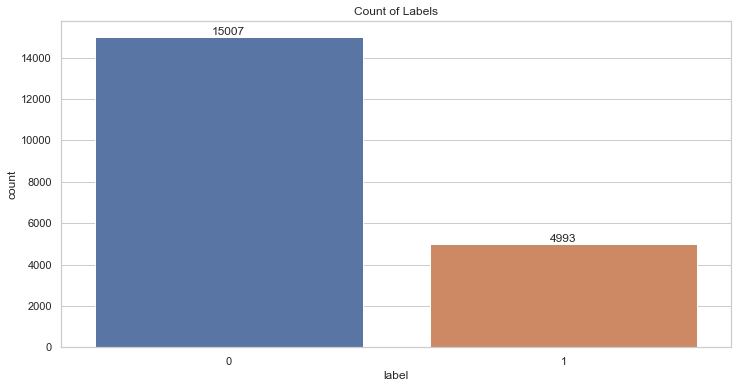

In [62]:
# Count of Labels
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(ax=ax, data=merged_df_labels, x='label').set_title('Count of Labels')
labelBar(ax, 100)
plt.show()

This dataset has a total of 4993 booking trips labeled as dangerous (1) and 15007 booking trips labeled as safe (0).

### 3.2 Count of Rating

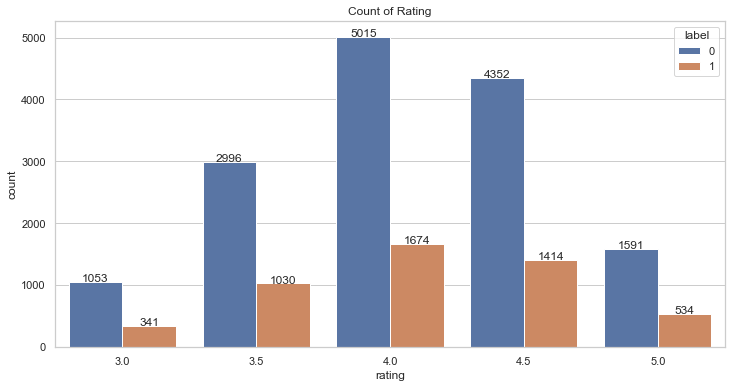

In [63]:
makeCountPlot(merged_df_labels, 'rating', 'Count of Rating', margin=0)

Ratings in this dataset seem to only consist 3 to 5 with a 0.5 increment. 

Most of the trips will have a rating 4, having a total of 5015 safe trips and 1674 dangerous trips.

### 3.3 Distribution of Driver Age

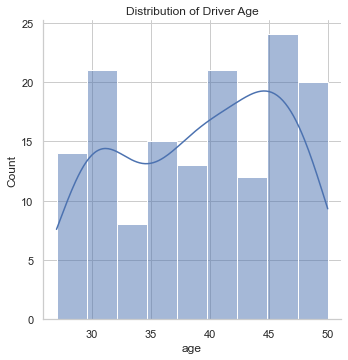

In [64]:
# Distribution of Driver Age
sns.displot(data=drivers_df, x='age', kde=True)
plt.title('Distribution of Driver Age')
plt.show()

Driver's age ranges from 28 to 50 years old.

### 3.4 Count of Trips for each Age

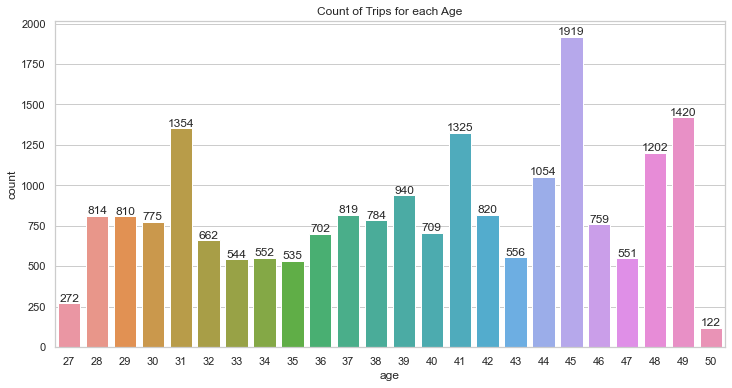

In [65]:
# Count of Trips for each age
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(ax=ax, data=merged_df_labels, x='age').set_title('Count of Trips for each Age')
labelBar(ax, 10)
plt.show()

Drivers of age 50 years old has the least number of trips made, only having 122. Whereas drivers of age 45 years old has the most number of trips made, having 1919 in total.

### 3.5 Avg Rating for each Driver's Age

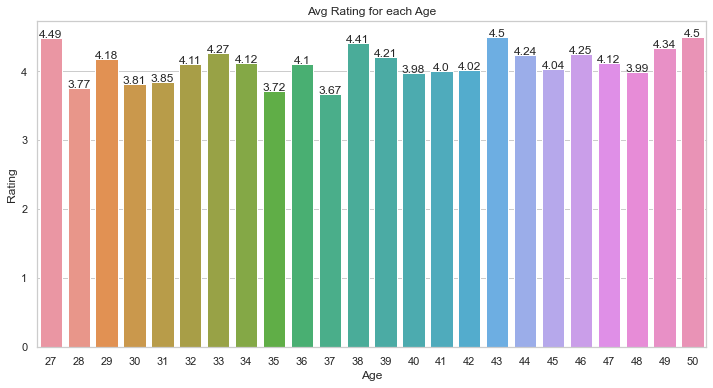

In [66]:
# Average rating for each age
avgRating_byDriver = merged_df_labels.groupby(['age'], as_index=False)['rating'].mean()
makeBarPlot(avgRating_byDriver, 'age', 'rating', 'Avg Rating for each Age', dp=2,
           x_label='Age', y_label='Rating', margin=0)

The age with the lowest average rating of 3.67 is 37 years old. Whereas the ages with the highest average rating of 4.5 are 43 and 50 years old. Reason why the rating is higher than the rest is because of the lower number of trips made, which can be seen in previous plot.

### 3.5 Percentage of Dangerous Trips for each Age

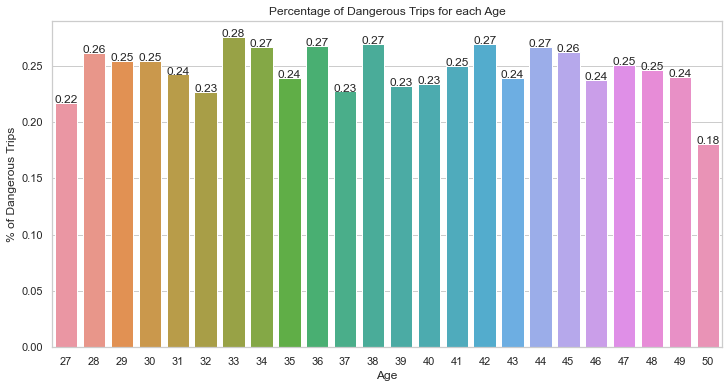

In [67]:
# Compute % of Dangerous Trips
dangerousDriving_byAge = merged_df_labels.groupby(['age'], as_index=False)['label'].sum()
trips_byAge = merged_df_labels.groupby(['age'], as_index=False)['booking_id'].count()
dangerousDriving_byAge['% Dangerous'] = dangerousDriving_byAge['label'] / trips_byAge['booking_id']

# Percentage of dangerous driving for each age
makeBarPlot(dangerousDriving_byAge, 'age', '% Dangerous', 'Percentage of Dangerous Trips for each Age', margin=0,
           x_label='Age', y_label='% of Dangerous Trips', dp=2)

Drivers of age 50 seems to have the least percentage of dangerous trips, 18%. Whereas drivers of age 33 has the highest percentage of dangerous trips, 28%. Additionally, there is not any pattern or trend in age and percentage of dangerous driving.

### 3.6 Pair Plot

In [68]:
cols = ['accuracy', 'bearing', 'acceleration', 'gyro', 'speed', 'label']
plot_df = merged_df_sensor[cols]

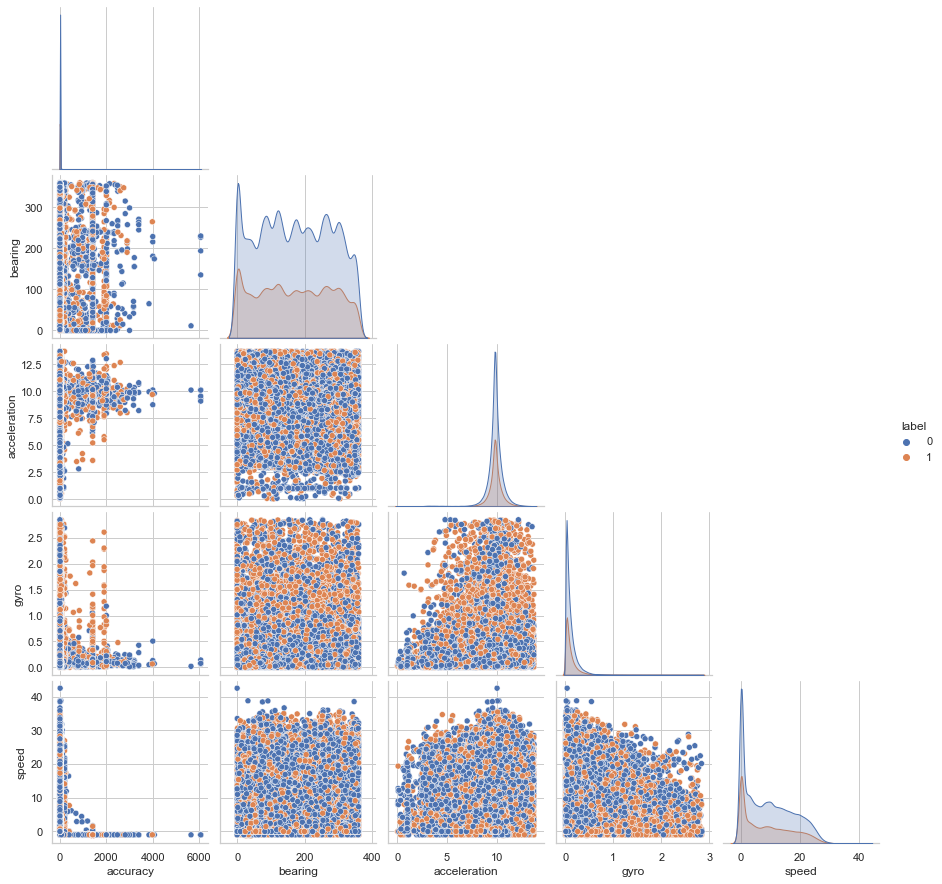

In [69]:
#do pairplot on subset of dataset (otherwise very slow)
varList=['accuracy', 'bearing', 'acceleration', 'gyro', 'speed']
pairDF=plot_df.sample(500_000)
sns.pairplot(pairDF, hue='label', corner=True, vars=varList)
plt.show()

### 3.7 Scatterplot

In [70]:
def makeScatterPlot(col1, col2):
    sns.lmplot(data=merged_df_sensor.sample(100_000), x=col1, y=col2,hue='label')
    plt.show()

<Figure size 1080x864 with 0 Axes>

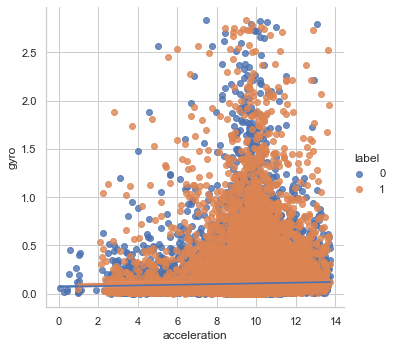

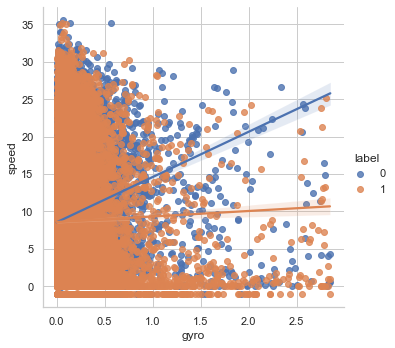

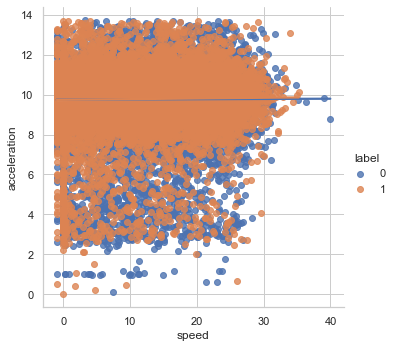

In [71]:
plt.figure(figsize=(15, 12))

# Plotting
makeScatterPlot('acceleration', 'gyro')
makeScatterPlot('gyro', 'speed')
makeScatterPlot('speed', 'acceleration')

plt.show()

### 3.8 Count of Trips for each Car Model

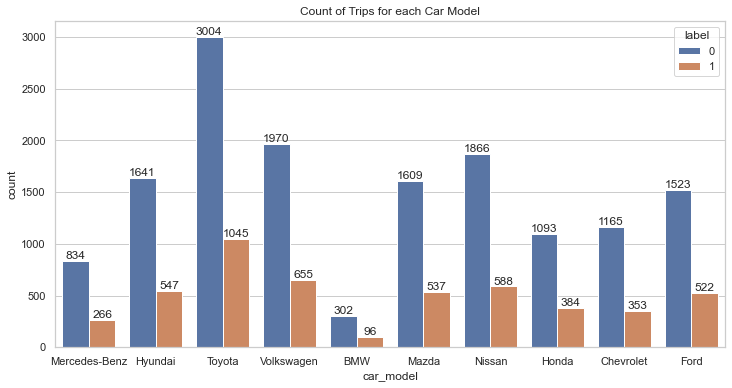

In [72]:
makeCountPlot(merged_df_labels, 'car_model', 'Count of Trips for each Car Model', margin=20)

Toyota seems to be the car that has the most amount of trips made, having a total of 3004 safe trips and 1045 dangerous trips. This car model is also the one with the most number of dangerous trips, reason could be because there are more trips for this car model. 

Whereas BMW has the least number of trips made, having only 302 safe trips and 96 dangerous trips.

### 3.9 Avg Rating per Trip for each Car Model

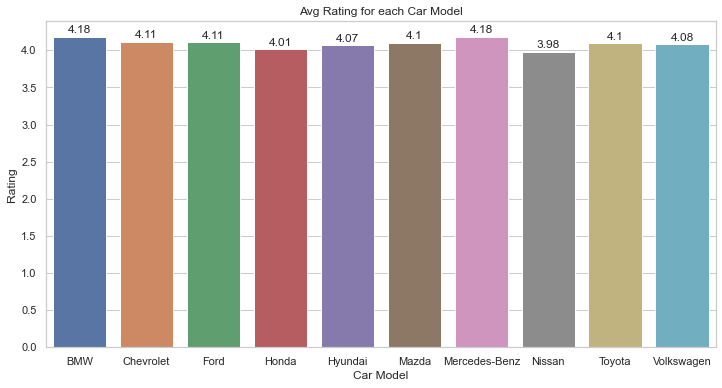

In [73]:
# Mean rating for each car model
avgRating_byCar = merged_df_labels.groupby(['car_model'], as_index=False)['rating'].mean()
makeBarPlot(avgRating_byCar, 'car_model', 'rating', 'Avg Rating for each Car Model', margin=0.05, dp=2,
           x_label='Car Model', y_label='Rating')

The car model with the highest average rating per trip of 4.18 are BMW and Mercedes-Benz The car model with the worst average of 3.98 is Nissan.

### 3.10 Count of Driver for each Car Make Year

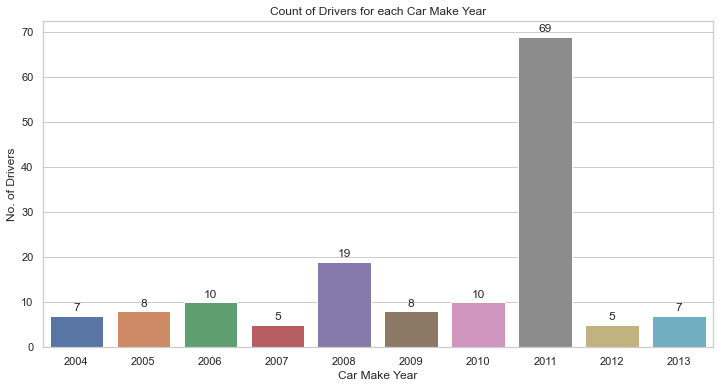

In [74]:
# Car make year for each driver
carMakeYear_driver = merged_df_labels.groupby('car_make_year', as_index=False)['driver_id'].nunique()
makeBarPlot(carMakeYear_driver, 'car_make_year', 'driver_id', 'Count of Drivers for each Car Make Year', margin=1
            ,x_label='Car Make Year', y_label='No. of Drivers')

Majority of the drivers owns a car that is made in 2011, car made in others years have significantly lower amount of drivers. 

### 3.11 Count of Ratings

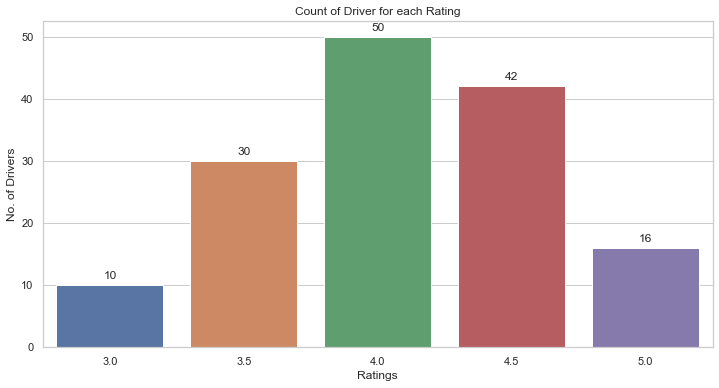

In [69]:
# Count of Ratings
avgRating_driver = drivers_df.groupby(['rating'], as_index=False)['driver_id'].count()
makeBarPlot(avgRating_driver, 'rating', 'driver_id', 'Count of Driver for each Rating', margin=1
            ,x_label='Ratings', y_label='No. of Drivers')

The ratings that the driver has ranges from 3 to 5 in increments of 0.5.
It seems that most drivers (60) will have a rating of 4. Whereas there are only 10 drivers with a lowest rating of 3 and 13 drivers with a highest rating of 5.

### 3.12 Percentage of Dangerous Driving for each Rating

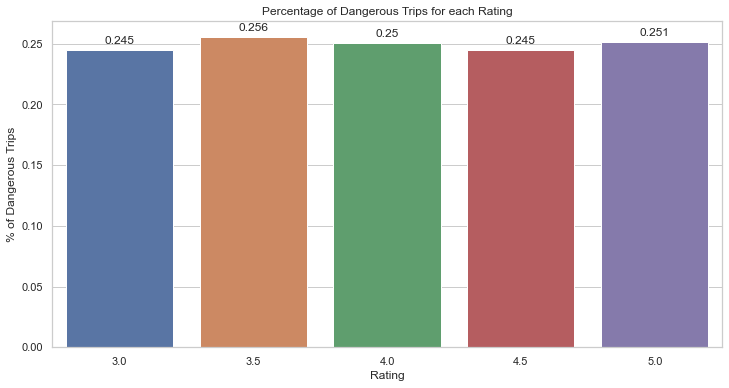

In [79]:
# Compute % of Dangerous Trips
dangerousDriving_byRating = merged_df_labels.groupby(['rating'], as_index=False)['label'].sum()
trips_byRating = merged_df_labels.groupby(['rating'], as_index=False)['booking_id'].count()
dangerousDriving_byRating['% Dangerous'] = dangerousDriving_byRating['label'] / trips_byRating['booking_id']

# Percentage of dangerous driving for each age
makeBarPlot(dangerousDriving_byRating, 'rating', '% Dangerous', 'Percentage of Dangerous Trips for each Rating', margin=0.005,
           x_label='Rating', y_label='% of Dangerous Trips', dp=3)

There seem to not be any pattern or relation between rating and percentage of dangerous trips. All ratings seem to have very similar percentage of dangerous trips of around 24.5% to 25.6%.

### 4. Setting up a one cell ETL
*Instead of running all the cells above to Extract, Transform and Load our data we have upcome with a combined version of what we did above (without the EDA parts).*<br><br>
<b>ETL Flow:</b><br>
- Extract: Connect to server & get raw data
- Transform: Changing datatype (to optimize RAM usage)
- Transform: Checking data to remove & also impute missing data
- Transform: Sensor data with missing safety labels will be drop (They are of no use for analysis or ML, since label is our target variable)
- Load: Load the different dataframes back into a different schema containing wrangled data
- Miscellaneous: Add relations to our wrangled data (cuz ERD needed)

In [3]:
# Combination of pervious code for ETL pipeline
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Connect to MSSQL server
server = 'JONI\SQLEXPRESS' # <- change server
database = 'Taxi_Trip'
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL Server')

connection = engine.connect()
cursor = connection.execute('SELECT * FROM dataLake.drivers')
drivers_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

cursor = connection.execute('SELECT * FROM dataLake.safety_labels')
safety_labels_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())

cursor = connection.execute('SELECT * FROM dataLake.sensor')
sensor_df = pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys())
connection.close()

# Function to get upper fence outliers
def returnUpper(df,columnName,magnitude=3):
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)
    upperFence = df[columnName].quantile(0.75) + (IQR * magnitude)
    outlier_df = df[columnName][(df[columnName]>=upperFence)]
    return outlier_df

# Changing datatype
drivers_df = drivers_df.astype({
    'car_make_year': 'int16',
    'rating': np.float16
})
drivers_df['date_of_birth'] = pd.to_datetime(drivers_df['date_of_birth'], format='%m/%d/%Y')

# Creating 'year' and 'month' column from date of birth
drivers_df['DOB_year'] = pd.DatetimeIndex(drivers_df['date_of_birth']).year
drivers_df['DOB_month'] = pd.DatetimeIndex(drivers_df['date_of_birth']).month_name().str[:3]
drivers_df = drivers_df[['driver_id', 'name', 'date_of_birth', 'DOB_year', 'DOB_month', 'gender',
                        'car_model', 'car_make_year', 'rating']]
drivers_df['age'] = 2022 - drivers_df['DOB_year'] 
drivers_df['car_age'] = 2022 - drivers_df['car_make_year'] 

# Changing datatype
sensor_df_cols = list(sensor_df.columns[1:])
temp_df = sensor_df[sensor_df_cols]

temp_df = temp_df.astype(np.float32)
temp_df['booking_id'] = sensor_df['booking_id'].copy()
cols = ['booking_id'] + sensor_df_cols
sensor_df = temp_df[cols].copy()

# Drop missing accuracy as it should not be imputed
sensor_df = sensor_df.dropna(how='any',axis=0,subset=['accuracy']).reset_index(drop=True)

imp_mean = IterativeImputer(
   estimator=LinearRegression(),
   random_state=1
)

# Passing all columns except 'booking_id'
sensor_df_cols = list(sensor_df.columns[1:])
num_df = sensor_df[sensor_df_cols]

# Imputing null values
sensor_list = imp_mean.fit_transform(num_df)
newSensor_df = pd.DataFrame(sensor_list, columns=sensor_df_cols)
newSensor_df['booking_id'] = sensor_df['booking_id'].copy()

# Feature Engineering
newSensor_df['acceleration'] = ((newSensor_df['acceleration_x'] ** 2 
                              + newSensor_df['acceleration_y'] ** 2 
                              + newSensor_df['acceleration_z'] ** 2) ** (1/2))

outlier_df = newSensor_df.loc[returnUpper(newSensor_df,'acceleration',6).index]
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'acceleration',6).index)

newSensor_df['gyro'] = ((newSensor_df['gyro_x'] ** 2 
                              + newSensor_df['gyro_y'] ** 2 
                              + newSensor_df['gyro_z'] ** 2) ** (1/2))
# Removing & Saving outliers
outlier_df = pd.concat([outlier_df,newSensor_df.loc[returnUpper(newSensor_df,'gyro',24).index]])
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'gyro',24).index)

outlier_df = pd.concat([outlier_df,newSensor_df.loc[returnUpper(newSensor_df,'speed',3).index]])
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'speed',3).index)

outlier_df = pd.concat([outlier_df,newSensor_df.loc[returnUpper(newSensor_df,'second',12).index]])
newSensor_df = newSensor_df.drop(returnUpper(newSensor_df,'second',12).index)

# Since inner join is used mismatched safety labels and sensor data will be dropped (if any)
# Joining Labels table to Sensor Data table
merged_df_sensor = newSensor_df.merge(safety_labels_df, on='booking_id', how='inner')
# Joining Labels table to Drivers table

outlier_df.to_sql('sensor_outliers',schema='dataCleansed',con=engine,if_exists='replace', index=False)
print('Sensor outliers data updated')
safety_labels_df.to_sql('safety_labels',schema='dataCleansed',con=engine,if_exists='replace', index=False)
print('Safety label data updated')
merged_df_sensor.drop(columns=['label','driver_id']).to_sql('sensor',schema='dataCleansed',con=engine,if_exists='replace',chunksize=500000,index_label='sensorKey', index=False)
print('Sensor data updated')
drivers_df.to_sql('drivers',schema='dataCleansed',con=engine,if_exists='replace', index=False)
print('Driver data updated')

# Changing datatypes
connection = engine.connect()
connection.execute('''
ALTER TABLE dataCleansed.drivers ALTER COLUMN driver_id BIGINT NOT NULL;

ALTER TABLE dataCleansed.safety_labels ALTER COLUMN booking_id BIGINT NOT NULL;
ALTER TABLE dataCleansed.safety_labels ALTER COLUMN driver_id BIGINT NOT NULL;

ALTER TABLE dataCleansed.sensor ALTER COLUMN sensorKey BIGINT NOT NULL;
ALTER TABLE dataCleansed.sensor ALTER COLUMN booking_id BIGINT NOT NULL;
''')
# Adding Primary Keys
connection.execute('''
ALTER TABLE dataCleansed.drivers ADD PRIMARY KEY (driver_id);

ALTER TABLE dataCleansed.safety_labels ADD PRIMARY KEY (booking_id);

ALTER TABLE dataCleansed.sensor ADD PRIMARY KEY (sensorKey);
''')
# Adding relations
connection.execute('''
ALTER TABLE dataCleansed.safety_labels ADD FOREIGN KEY (driver_id) REFERENCES dataCleansed.drivers (driver_id);

ALTER TABLE dataCleansed.sensor ADD FOREIGN KEY (booking_id) REFERENCES dataCleansed.safety_labels (booking_id);
''')
connection.close()


del engine
print('\nETL ran successfully - Finished Running')

Sensor outliers data updated
Safety label data updated
Sensor data updated
Driver data updated

ETL ran successfully - Finished Running
